In [54]:
import pandas as pd

# Load the dataset (assuming it's in CSV format)
df = pd.read_csv('/content/marketing_campaign_dataset.csv')

# Display first few rows to inspect the data
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Data types of columns to ensure correct types
print(df.dtypes)


   Campaign_ID              Company Campaign_Type Target_Audience Duration  \
0            1  Innovate Industries         Email       Men 18-24  30 days   
1            2       NexGen Systems         Email     Women 35-44  60 days   
2            3    Alpha Innovations    Influencer       Men 25-34  30 days   
3            4   DataTech Solutions       Display        All Ages  60 days   
4            5       NexGen Systems         Email       Men 25-34  15 days   

  Channel_Used  Conversion_Rate Acquisition_Cost   ROI     Location  Language  \
0   Google Ads             0.04       $16,174.00  6.29      Chicago   Spanish   
1   Google Ads             0.12       $11,566.00  5.61     New York    German   
2      YouTube             0.07       $10,200.00  7.18  Los Angeles    French   
3      YouTube             0.11       $12,724.00  5.55        Miami  Mandarin   
4      YouTube             0.05       $16,452.00  6.50  Los Angeles  Mandarin   

   Clicks  Impressions  Engagement_Score    

In [55]:
# Convert 'Acquisition_Cost' and 'ROI' to numeric (remove the $ sign and commas)
df['Acquisition_Cost'] = df['Acquisition_Cost'].replace({'\$': '', ',': ''}, regex=True).astype(float)
df['ROI'] = df['ROI'].astype(float)

# Convert 'Date' to datetime, let pandas infer the format
df['Date'] = pd.to_datetime(df['Date'])

# Check the data types and confirm the change
print(df.dtypes)

# Check for missing values again after cleaning
print(df.isnull().sum())


Campaign_ID                  int64
Company                     object
Campaign_Type               object
Target_Audience             object
Duration                    object
Channel_Used                object
Conversion_Rate            float64
Acquisition_Cost           float64
ROI                        float64
Location                    object
Language                    object
Clicks                       int64
Impressions                  int64
Engagement_Score             int64
Customer_Segment            object
Date                datetime64[ns]
dtype: object
Campaign_ID         0
Company             0
Campaign_Type       0
Target_Audience     0
Duration            0
Channel_Used        0
Conversion_Rate     0
Acquisition_Cost    0
ROI                 0
Location            0
Language            0
Clicks              0
Impressions         0
Engagement_Score    0
Customer_Segment    0
Date                0
dtype: int64


In [56]:
# Function to extract the lower and upper bounds of age
def extract_age_range(target):
    # Check if the Target_Audience contains age range information
    if 'All Ages' in target:
        return None, None  # Or you could assign specific values (e.g., -1, -1)

    # Extract numerical age range from 'Target_Audience' (format like 'Men 18-24')
    try:
        age_range = target.split(' ')[1]  # Get '18-24' from 'Men 18-24'
        lower_age, upper_age = age_range.split('-')  # Split into ['18', '24']
        return int(lower_age), int(upper_age)
    except Exception as e:
        # Handle cases where the format is different than expected
        return None, None

# Apply the function to extract lower and upper age bounds
df[['Age_Lower', 'Age_Upper']] = df['Target_Audience'].apply(lambda x: pd.Series(extract_age_range(x)))

# Verify the changes
print(df[['Target_Audience', 'Age_Lower', 'Age_Upper']].head())


  Target_Audience  Age_Lower  Age_Upper
0       Men 18-24       18.0       24.0
1     Women 35-44       35.0       44.0
2       Men 25-34       25.0       34.0
3        All Ages        NaN        NaN
4       Men 25-34       25.0       34.0


In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

# Step 1: Create the target variable (Lead Converted)
# We'll assume a threshold of 0.1 for Conversion Rate to define conversion.
df['Lead_Converted'] = (df['Conversion_Rate'] > 0.04).astype(int)

# Step 2: Select relevant features (same as before)
X = df[['Clicks', 'Impressions', 'Engagement_Score', 'Acquisition_Cost']]
y = df['Lead_Converted']

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Feature scaling (important for some models, though Random Forest may not need it)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# Step 6: Make predictions
y_pred = rf_classifier.predict(X_test_scaled)

# Step 7: Evaluate the model using classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.74015
Precision: 0.7526652998462326
Recall: 0.9753254516471839
F1 Score: 0.8496499450326911


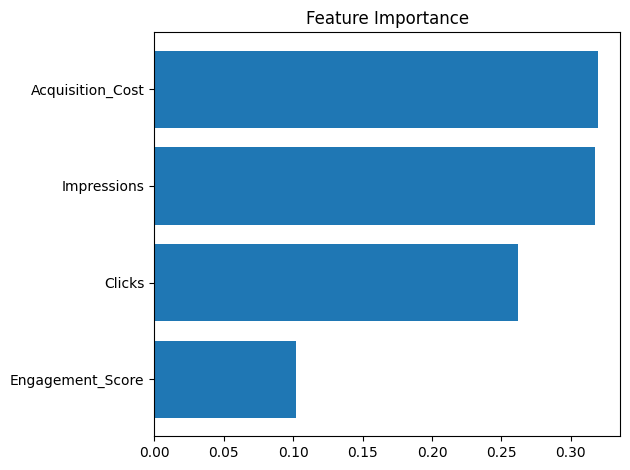

In [77]:
import matplotlib.pyplot as plt
import pandas as pd

features = X.columns
importances = rf_classifier.feature_importances_
indices = importances.argsort()

plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

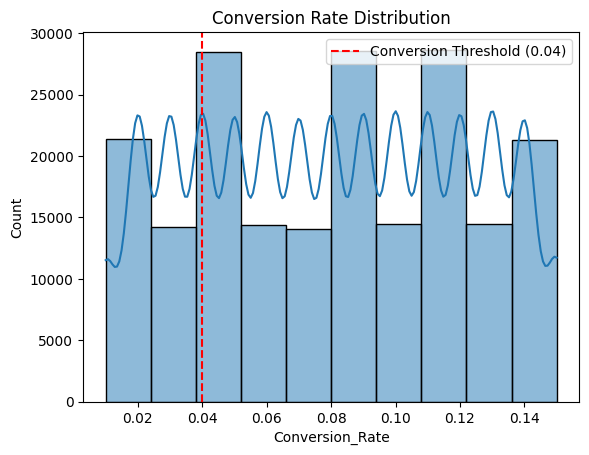

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['Conversion_Rate'], bins=10, kde=True)
plt.axvline(0.04, color='red', linestyle='--', label='Conversion Threshold (0.04)')
plt.title('Conversion Rate Distribution')
plt.legend()
plt.show()

In [104]:
# Grouping by Target Audience
audience_performance = df.groupby('Target_Audience').agg({
    'Conversion_Rate': 'mean',
    'ROI': 'mean',
    'Acquisition_Cost': 'mean'
}).reset_index()

print(audience_performance)

  Target_Audience  Conversion_Rate       ROI  Acquisition_Cost
0        All Ages         0.079975  5.005174      12501.914915
1       Men 18-24         0.080240  4.982853      12523.299195
2       Men 25-34         0.080132  5.020627      12480.618344
3     Women 25-34         0.079899  4.997351      12500.490940
4     Women 35-44         0.080102  5.006330      12515.623857


In [65]:
# Group by Channel Used and calculate average performance metrics
channel_performance = df.groupby('Channel_Used').agg({
    'Conversion_Rate': 'mean',
    'ROI': 'mean',
    'Acquisition_Cost': 'mean'
}).reset_index()

print(channel_performance)


  Channel_Used  Conversion_Rate       ROI  Acquisition_Cost
0        Email         0.080282  4.996487      12526.387809
1     Facebook         0.079992  5.018699      12510.900942
2   Google Ads         0.080183  5.003141      12528.031401
3    Instagram         0.079886  4.988706      12491.760002
4      Website         0.080183  5.014167      12487.814748
5      YouTube         0.079889  4.993754      12481.390213


In [66]:
# Group by Duration and calculate average performance metrics
duration_performance = df.groupby('Duration').agg({
    'Conversion_Rate': 'mean',
    'ROI': 'mean',
    'Acquisition_Cost': 'mean'
}).reset_index()

print(duration_performance)


  Duration  Conversion_Rate       ROI  Acquisition_Cost
0  15 days         0.080101  4.996720      12507.595994
1  30 days         0.080177  5.008887      12490.209332
2  45 days         0.079952  4.997627      12505.100838
3  60 days         0.080048  5.006480      12514.778907


In [67]:
# Group by Location and calculate average performance metrics
location_performance = df.groupby('Location').agg({
    'Conversion_Rate': 'mean',
    'ROI': 'mean',
    'Acquisition_Cost': 'mean'
}).reset_index()

print(location_performance)


      Location  Conversion_Rate       ROI  Acquisition_Cost
0      Chicago         0.080134  5.001590      12515.161585
1      Houston         0.079948  5.007203      12454.387245
2  Los Angeles         0.080013  5.010876      12532.539765
3        Miami         0.080047  5.012282      12515.208001
4     New York         0.080204  4.980228      12504.317984


In [105]:
# General summary statistics
print("Summary Statistics of the dataset:\n")
print(df[['Conversion_Rate', 'ROI', 'Acquisition_Cost']].describe())

Summary Statistics of the dataset:

       Conversion_Rate            ROI  Acquisition_Cost
count    200000.000000  200000.000000     200000.000000
mean          0.080070       5.002438      12504.393040
std           0.040602       1.734488       4337.664545
min           0.010000       2.000000       5000.000000
25%           0.050000       3.500000       8739.750000
50%           0.080000       5.010000      12496.500000
75%           0.120000       6.510000      16264.000000
max           0.150000       8.000000      20000.000000


In [108]:
# Best performing campaigns based on ROI
best_roi_campaigns = df[['Campaign_ID', 'Company', 'Campaign_Type', 'ROI']].sort_values(by='ROI', ascending=False)
print("\nTop 5 Campaigns by ROI:\n", best_roi_campaigns.head())


Top 5 Campaigns by ROI:
         Campaign_ID              Company Campaign_Type  ROI
65640         65641    Alpha Innovations        Search  8.0
143790       143791    Alpha Innovations    Influencer  8.0
143503       143504  Innovate Industries    Influencer  8.0
121639       121640             TechCorp    Influencer  8.0
120917       120918             TechCorp  Social Media  8.0


In [109]:
# Best performing campaigns based on Conversion Rate
best_conversion_rate_campaigns = df[['Campaign_ID', 'Company', 'Campaign_Type', 'Conversion_Rate']].sort_values(by='Conversion_Rate', ascending=False)
print("\nTop 5 Campaigns by Conversion Rate:\n", best_conversion_rate_campaigns.head())


Top 5 Campaigns by Conversion Rate:
         Campaign_ID              Company Campaign_Type  Conversion_Rate
111242       111243  Innovate Industries        Search             0.15
111243       111244       NexGen Systems  Social Media             0.15
7350           7351       NexGen Systems       Display             0.15
111250       111251  Innovate Industries         Email             0.15
130384       130385             TechCorp         Email             0.15


(200000, 12)


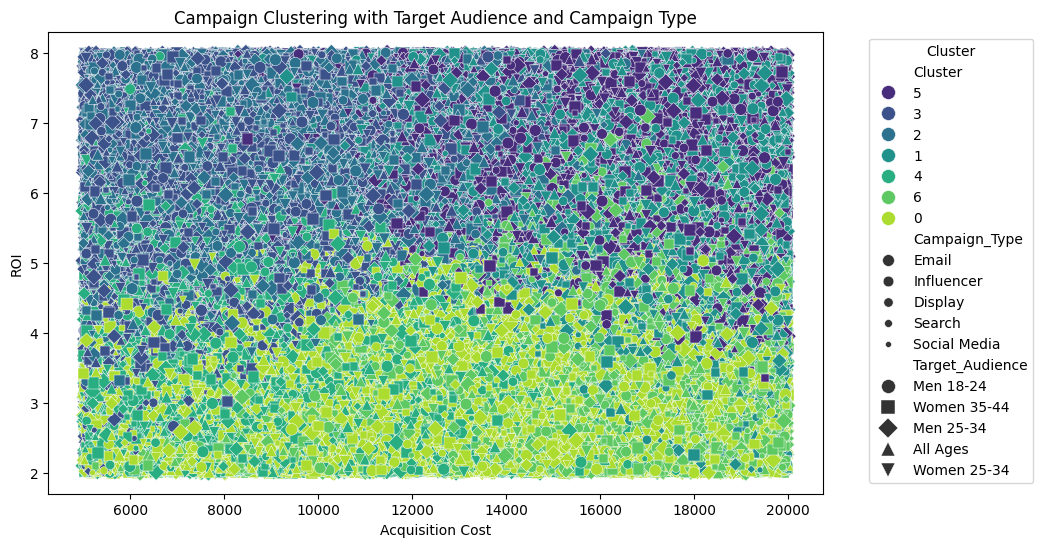

         Acquisition_Cost       ROI  Conversion_Rate   Duration  \
Cluster                                                           
0            12676.908630  3.265347         0.039008  38.058268   
1            16358.625340  5.857280         0.103321  22.584889   
2             9506.503056  6.336678         0.047818  23.968115   
3             8581.288151  6.048421         0.098290  52.128112   
4             9049.683278  3.737525         0.110330  24.194675   
5            16098.910544  6.377959         0.053451  50.851946   
6            15224.856588  3.618603         0.113513  51.054537   

        Most_Frequent_Target_Audience Most_Frequent_Campaign_Type  
Cluster                                                            
0                           Men 18-24                       Email  
1                            All Ages                  Influencer  
2                         Women 25-34                      Search  
3                           Men 25-34                   

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Assuming the dataset is loaded as 'df'
# df = pd.read_csv('your_dataset.csv')  # Replace this with your actual dataset load method

# Clean and prepare the data
# Remove $ sign and commas from 'Acquisition_Cost' and convert it to float
df['Acquisition_Cost'] = df['Acquisition_Cost'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Remove ' days' from 'Duration' column and convert to integer
df['Duration'] = df['Duration'].astype(str).str.replace(' days', '').astype(int)

# Normalize the numeric features
scaler = StandardScaler()
numeric_features = ['Acquisition_Cost', 'ROI', 'Conversion_Rate', 'Duration']
df_scaled = scaler.fit_transform(df[numeric_features])

# One-hot encode categorical columns: 'Target_Audience' and 'Campaign_Type'
df_encoded = pd.get_dummies(df[['Target_Audience', 'Campaign_Type']], drop_first=True)

# Combine the scaled numeric features with the encoded categorical features
X = np.concatenate([df_scaled, df_encoded], axis=1)

# Check the shape of X to ensure it combines correctly
print(X.shape)

# Apply K-Means clustering with 6 clusters
kmeans = KMeans(n_clusters=7, random_state=42)  # Change n_clusters to 6 or any desired number
df['Cluster'] = kmeans.fit_predict(X)

# Add the cluster labels back to the DataFrame
df['Cluster'] = df['Cluster'].astype(str)

# Visualize the clusters
plt.figure(figsize=(10, 6))

# Plot using the 'Target_Audience' and 'Campaign_Type' as categorical variables
sns.scatterplot(x='Acquisition_Cost', y='ROI', hue='Cluster', style='Target_Audience', size='Campaign_Type',
                data=df, palette='viridis', s=100, markers=["o", "s", "D", "^", "v"])

# Title and labels
plt.title('Campaign Clustering with Target Audience and Campaign Type')
plt.xlabel('Acquisition Cost')
plt.ylabel('ROI')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Cluster profile: Look at the mean values of each cluster for numeric features
cluster_profiles = df.groupby('Cluster')[['Acquisition_Cost', 'ROI', 'Conversion_Rate', 'Duration']].mean()

# Now include most frequent values (mode) for 'Target_Audience' and 'Campaign_Type' within each cluster
target_audience_mode = df.groupby('Cluster')['Target_Audience'].agg(lambda x: x.mode()[0])
campaign_type_mode = df.groupby('Cluster')['Campaign_Type'].agg(lambda x: x.mode()[0])

# Combine the numerical cluster profile with categorical mode values
cluster_profiles['Most_Frequent_Target_Audience'] = target_audience_mode
cluster_profiles['Most_Frequent_Campaign_Type'] = campaign_type_mode

# Print the cluster profile with both numeric and categorical features
print(cluster_profiles)




In [ ]:
 1. Tailored Campaign Strategies
Each cluster reveals a common pattern that helps you design personalized marketing strategies:

Cluster 1 (High Conversion Rate, Low Duration, "All Ages", "Influencer"):
→ Short campaigns using influencers work well across all ages.
→ Ideal for broad, fast-response promotions.

Cluster 3 (High ROI and High Conversion Rate, "Men 25-34", "Search"):
→ Search ads targeted at this group are very efficient.
→ Scale this segment for performance.

Cluster 0 (Low conversion and ROI, "Men 18-24", "Email"):
→ Email might not be effective for this segment — consider testing new channels.


2. Channel Optimization
Influencer campaigns (Clusters 1 & 4) yield high conversion rates but differ in ROI and duration — suggesting different audience-channel fit.

Search campaigns seem effective across clusters — particularly for Men 25-34 and Women 25-34.


If the goal is ROI:
Prioritize clusters like Cluster 2 (Women 25–34, Search) and Cluster 5 (Men 25–34, Email) with ROI above 6.

If the goal is high conversion:
Focus on Cluster 4 and Cluster 6.



 Men 18-24 + Influencer (Cluster 4) performs better than Men 18-24 + Email (Cluster 0).
 - Try moving more budget from email to influencer for this group.